<h2>タスク説明</h2>
本コンペティションでは旅行会社の保有する顧客データ（属性や志向、営業担当との接触履歴等）を元に、旅行パッケージの成約率を予測するモデルを構築していきます。<br><br>
URL:https://signate.jp/competitions/1376

| ヘッダ名称                  | 値例                  | データ型   | 説明                                        |
|----------------------------|----------------------|------------|---------------------------------------------|
| id                         | 0                    | int64      | 顧客ID                                      |
| Age                        | 50歳                 | str        | 顧客の年齢                                  |
| TypeofContact              | Self Enquiry         | str        | 顧客への連絡・接触方法                      |
| CityTier                   | 2                    | int64      | 都市層(1>2>3)                                |
| DurationOfPitch            | 900秒                | str        | 営業担当者による顧客への商品のセールス時間    |
| Occupation                 | Large Business       | str        | 顧客の職業                                  |
| Gender                     | male                 | str        | 顧客の性別                                  |
| NumberOfPersonVisiting      | 1                    | int64      | 予定している旅行の同行者の数                |
| NumberOfFollowups          | 4.0                  | float64    | セールス後に営業担当者が行ったフォローアップの回数 |
| ProductPitched             | Basic                | str        | 営業担当者のセールスした商品の種類          |
| PreferredPropertyStar      | 3.0                  | float64    | 顧客の希望するホテルのランク                |
| NumberOfTrips              | 5                    | str        | 顧客の年間旅行数                            |
| Passport                   | 1                    | int64      | パスポートの所持(0: 不所持、1: 所持)        |
| PitchSatisfactionScore     | 4                    | int64      | 営業担当者のセールストークに対する顧客の満足度|
| Designation                | Executive            | str        | 顧客の役職                                  |
| MonthlyIncome              | 253905.0             | str        | 顧客の月収                                  |
| customer_info              | 未婚 車未所持 子供なし | str        | 顧客の情報のメモ(婚姻状況や車の有無、旅行への子どもの同伴の有無) |
| ProdTaken(目的変数)         | 1                    | int64      | 商品の契約状態(0:不成約、1:成約)            |

In [41]:
# NumPy: 数値計算用ライブラリ
import numpy as np

# pandas: データ操作・分析用ライブラリ
import pandas as pd

# Matplotlib: グラフ描画用ライブラリ
import matplotlib.pyplot as plt

# Seaborn: 統計データの可視化用ライブラリ（Matplotlibの上位互換）
import seaborn as sns

# LightGBM
import lightgbm as lgb

# 評価指標
from sklearn.metrics import roc_auc_score, roc_curve, auc

# 前処理
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# バリデーション
from sklearn.model_selection import train_test_split

# SHAP
import shap

import warnings
warnings.filterwarnings("ignore")

# 全ての列を表示
pd.set_option('display.max_columns', None)
# 全ての行を表示  
pd.set_option('display.max_rows', None)     

In [23]:
# 前処理済みのデータの読み込み
df_train = pd.read_csv('./data/processed_train.csv')
df_test = pd.read_csv('./data/processed_test.csv')

In [24]:
# 確認
df_train.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,marital_status,car_ownership,children,ProdTaken
0,0,50,Self Enquiry,2,900.0,Large Business,Male,1.0,4.0,Basic,3.0,5.0,1,4,Executive,253905.0,未婚,車未所持,0.0,1.0
1,1,56,Company Invited,1,840.0,Salaried,Male,1.0,4.0,Standard,3.0,2.0,1,4,Senior Manager,404475.0,離婚済み,車所持,0.0,0.0
2,2,0,Self Enquiry,1,600.0,Large Business,Female,1.0,3.0,Basic,3.0,4.0,0,4,Executive,278145.0,結婚済み,車未所持,0.0,1.0
3,3,37,Self Enquiry,2,1080.0,Small Business,Female,1.0,3.0,Standard,4.0,1.0,0,5,Senior Manager,326805.0,離婚済み,車所持,0.0,0.0
4,4,48,Company Invited,3,1020.0,Small Business,Female,1.0,3.0,Basic,4.0,4.0,0,4,Executive,258435.0,独身,車所持,0.0,1.0


In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3489 non-null   int64  
 2   TypeofContact           3483 non-null   object 
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3368 non-null   float64
 5   Occupation              3489 non-null   object 
 6   Gender                  3489 non-null   object 
 7   NumberOfPersonVisiting  3489 non-null   float64
 8   NumberOfFollowups       3456 non-null   float64
 9   ProductPitched          3489 non-null   object 
 10  PreferredPropertyStar   3489 non-null   float64
 11  NumberOfTrips           3450 non-null   float64
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64  
 14  Designation             3489 non-null   

In [26]:
df_train['Occupation'].value_counts()

Occupation
Small Business    1727
Salaried          1401
Large Business     361
Name: count, dtype: int64

In [28]:
# カテゴリーマッピング
TypeofContact_map = {'Self Enquiry': 1, 'Company Invited': 2}
Occupation_map      = {'Small Business': 1, 'Salaried': 2, 'Large Business': 3}
Gender_map          = {'Female': 1, 'Male': 2}
ProductPitched_map  = { 'Basic': 1, 'Deluxe': 2, 'Standard': 3, 'Super Deluxe': 4, 'King': 5}
Designation_map     = {'Executive': 1, 'Manager': 2, 'Senior Manager': 3, 'AVP': 4, 'VP': 5}
MaritalStatus_map   = {'結婚済み': 1, '離婚済み': 2, '独身': 3, '未婚': 4}
CarOwnerShip_map    = {'車未所持': 1, '車所持': 2}

# int型に変換
df_train['TypeofContact'] = df_train['TypeofContact'].map(TypeofContact_map)
df_train['Occupation'] = df_train['Occupation'].map(Occupation_map)
df_train['Gender'] = df_train['Gender'].map(Gender_map)
df_train['ProductPitched'] = df_train['ProductPitched'].map(ProductPitched_map)
df_train['Designation'] = df_train['Designation'].map(Designation_map)
df_train['marital_status'] = df_train['marital_status'].map(MaritalStatus_map)
df_train['car_ownership'] = df_train['car_ownership'].map(CarOwnerShip_map)

df_test['TypeofContact'] = df_test['TypeofContact'].map(TypeofContact_map)
df_test['Occupation'] = df_test['Occupation'].map(Occupation_map)
df_test['Gender'] = df_test['Gender'].map(Gender_map)
df_test['ProductPitched'] = df_test['ProductPitched'].map(ProductPitched_map)
df_test['Designation'] = df_test['Designation'].map(Designation_map)
df_test['marital_status'] = df_test['marital_status'].map(MaritalStatus_map)
df_test['car_ownership'] = df_test['car_ownership'].map(CarOwnerShip_map)

In [29]:
# 確認
df_train.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,marital_status,car_ownership,children,ProdTaken
0,0,50,1.0,2,900.0,3,2,1.0,4.0,1,3.0,5.0,1,4,1,253905.0,4,1,0.0,1.0
1,1,56,2.0,1,840.0,2,2,1.0,4.0,3,3.0,2.0,1,4,3,404475.0,2,2,0.0,0.0
2,2,0,1.0,1,600.0,3,1,1.0,3.0,1,3.0,4.0,0,4,1,278145.0,1,1,0.0,1.0
3,3,37,1.0,2,1080.0,1,1,1.0,3.0,3,4.0,1.0,0,5,3,326805.0,2,2,0.0,0.0
4,4,48,2.0,3,1020.0,1,1,1.0,3.0,1,4.0,4.0,0,4,1,258435.0,3,2,0.0,1.0


In [30]:
df_train['children'].value_counts()

children
1.0    1636
0.0     985
2.0     763
3.0      68
Name: count, dtype: int64

In [31]:
# 型のチェック
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3489 non-null   int64  
 2   TypeofContact           3483 non-null   float64
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3368 non-null   float64
 5   Occupation              3489 non-null   int64  
 6   Gender                  3489 non-null   int64  
 7   NumberOfPersonVisiting  3489 non-null   float64
 8   NumberOfFollowups       3456 non-null   float64
 9   ProductPitched          3489 non-null   int64  
 10  PreferredPropertyStar   3489 non-null   float64
 11  NumberOfTrips           3450 non-null   float64
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64  
 14  Designation             3489 non-null   

In [32]:
# 特徴量とターゲットの分割
x_train = df_train.drop(columns=['id', 'ProdTaken'])
y_train = df_train['ProdTaken']

# トレーニングデータとテストデータの分割
x_tr, x_va, y_tr, y_va = train_test_split(x_train, y_train, test_size=0.2, random_state=123)
print(x_tr.shape, x_va.shape, y_tr.shape, y_va.shape)

(2791, 18) (698, 18) (2791,) (698,)


In [33]:
# パラメータの設定
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'verbosity': -1,
    'random_state': 1,
    'max_bin': 255
}

# LightGBMのデータセット形式に変換
dtrain = lgb.Dataset(x_tr, label=y_tr)
dvalid = lgb.Dataset(x_va, label=y_va)

model = lgb.train(
    params,
    dtrain,
    num_boost_round= 10000,
    valid_sets=dvalid,
    callbacks= [lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(1)]
)

[1]	valid_0's binary_error: 0.133238
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_error: 0.133238
[3]	valid_0's binary_error: 0.133238
[4]	valid_0's binary_error: 0.133238
[5]	valid_0's binary_error: 0.133238
[6]	valid_0's binary_error: 0.133238
[7]	valid_0's binary_error: 0.133238
[8]	valid_0's binary_error: 0.130372
[9]	valid_0's binary_error: 0.12894
[10]	valid_0's binary_error: 0.126074
[11]	valid_0's binary_error: 0.124642
[12]	valid_0's binary_error: 0.127507
[13]	valid_0's binary_error: 0.12894
[14]	valid_0's binary_error: 0.127507
[15]	valid_0's binary_error: 0.127507
[16]	valid_0's binary_error: 0.12894
[17]	valid_0's binary_error: 0.126074
[18]	valid_0's binary_error: 0.123209
[19]	valid_0's binary_error: 0.123209
[20]	valid_0's binary_error: 0.118911
[21]	valid_0's binary_error: 0.117479
[22]	valid_0's binary_error: 0.116046
[23]	valid_0's binary_error: 0.116046
[24]	valid_0's binary_error: 0.117479
[25]	valid_0's binary_error: 0.116046


In [34]:
# 作成したモデルで予測値を算出
y_pred = model.predict(x_va, num_iteration=model.best_iteration)

# ROC_AUCを計算
auc_score = roc_auc_score(y_va, y_pred)
print('ROC-AUC: {:.2f}'.format(auc_score))

ROC-AUC: 0.84


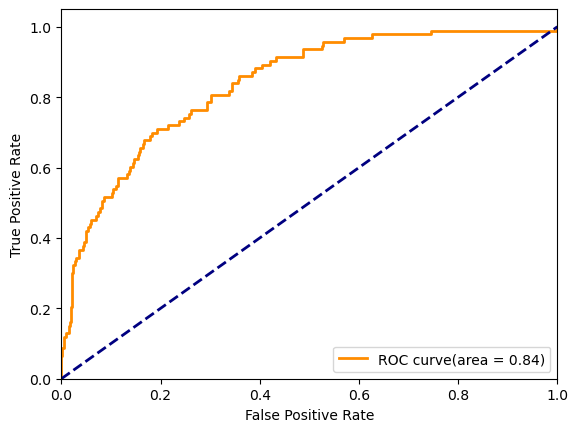

In [35]:
# ROCカーブを計算
fpr, tpr, _ = roc_curve(y_va, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve(area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

モデルの性能は良好: AUCが0.83と高く、曲線の形状も良好であることから、このモデルは高い分類性能を持っていると考えられます。
ROCカープについて極端な傾向はない。

In [36]:
# テストデータを用いて予測します。
# x_testとid_testを定義
x_test = df_test.drop(['id'], axis=1)
id_test = df_test[['id']]
# 学習モデルによる推論
y_test_pred = model.predict(x_test)

In [37]:
from datetime import datetime

# 提出ファイルの作成
df_submit = pd.DataFrame({"id": id_test["id"], "ProdTaken": y_test_pred})
print(df_submit.head(5))

# 今日の日付を取得
today = datetime.today().strftime('%Y-%m-%d')

# CSVファイルを保存
file_name = f"./output/submission_{today}_LGBM.csv"
df_submit.to_csv(file_name, index=None, header=False)

     id  ProdTaken
0  3489   0.051714
1  3490   0.248371
2  3491   0.466283
3  3492   0.251533
4  3493   0.266540


2024/08/04 時点では全体の60%内に入る結果とはなりました。

![スクリーンショット 2024-08-04 213112.png](<attachment:スクリーンショット 2024-08-04 213112.png>)
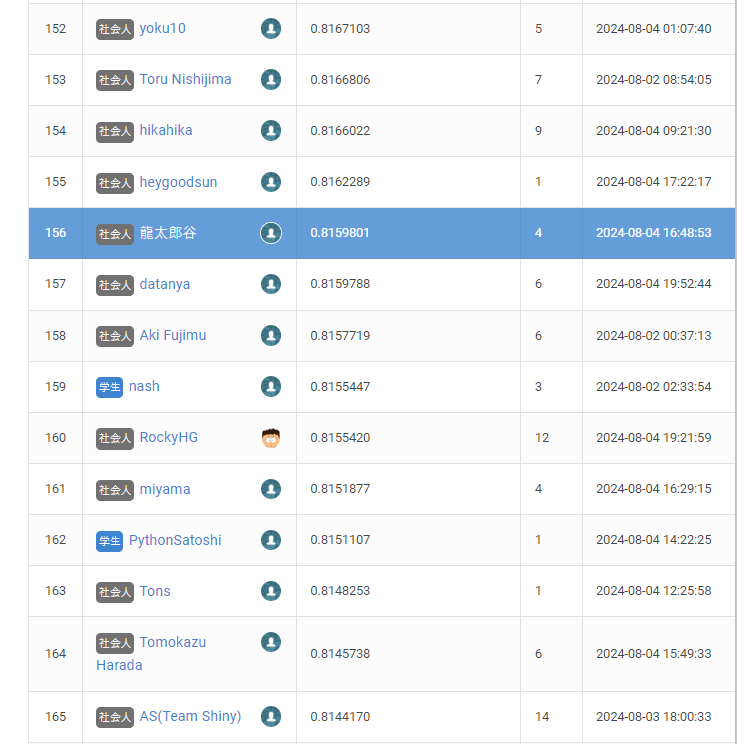

### モデルの特徴をSHAPで理解

In [38]:
# SHAPのExplainerを用いて、モデルのSHAP値を計算
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

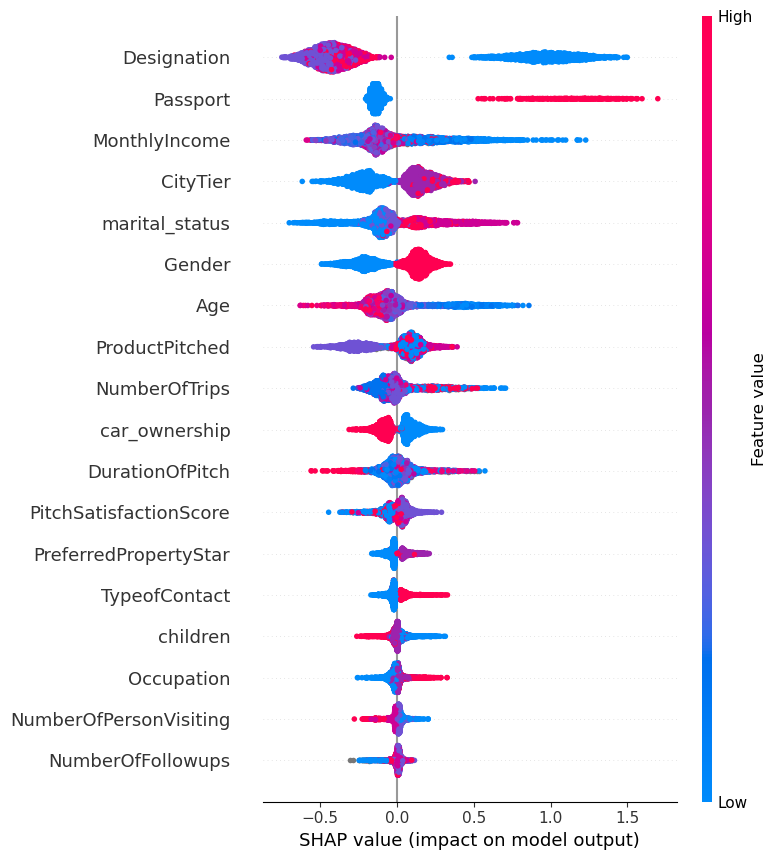

In [39]:
# SHAP値の要約プロットを生成
shap.summary_plot(shap_values, x_test)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

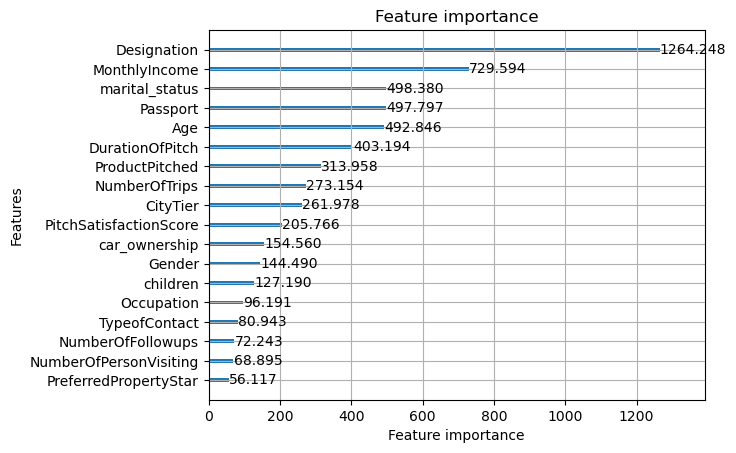

In [40]:
lgb.plot_importance(model, max_num_features=30, importance_type='gain')

2つのグラフから結果を見ると、算出方法が異なるため特徴量の順序など若干異なる部分があるものの、SHAP値とほぼ同様の傾向があることが判明した。